# Option Framework

**Papers**
* [Option Framework](https://www.sciencedirect.com/science/article/pii/S0004370299000521)
* [Learning Options in Reinforcement Learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.2402&rep=rep1&type=pdf)


In this notebook I'm exploring the Option Framework while implementing the algorithm proposed at the "Learning Options in Reinforcement Learning" paper.
The Option Framework tries to address challenges like: learning, planning, and representing knowledge at multiple levels of temporal abstraction. To do that they introduce a new notion of action which they call Option, which is basically an extension of the action as we know. 


In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
from gym import core, spaces

## Environment

The four rooms environment used at the paper, is usefull to show how the options are found and how they can use the bottleneck states to help the agent find the goal.

In [ ]:
 # https://github.com/jeanharb/option_critic/tree/master/fourrooms

class Fourrooms:
    def __init__(self):
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])

        # From any state the agent can perform one of four actions, up, down, left or right
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(np.sum(self.occupancy == 0))

        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i, j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k,v in self.tostate.items()}

        self.goal = 62
        self.init = 0

    def empty_around(self, cell):
        avail = []
        for action in range(self.action_space.n):
            nextcell = tuple(cell + self.directions[action])
            if not self.occupancy[nextcell]:
                avail.append(nextcell)
        return avail
      
    def render_values(self, states):
      current_grid = np.array(self.occupancy)
      pos = 0
      for i in range(len(current_grid)):
        for j in range(len(current_grid[0])):
          val = current_grid[i, j]
          if val != 1:
            if pos in states.keys():
              current_grid[i, j] = states[pos]
            pos += 1
          else:
            current_grid[i, j] = -10
      return current_grid

          
    def render_pos(self):
      current_grid = np.array(self.occupancy)
      pos = 0
      for i in range(len(current_grid)):
        for j in range(len(current_grid[0])):
          val = current_grid[i, j]
          if val != 1:
            current_grid[i, j] = pos
            pos += 1
          else:
            current_grid[i, j] = 0
      return current_grid

    def reset(self):
        #state = self.rng.choice(self.init_states)
        state = self.init
        self.currentcell = self.tocell[state]
        return state

    def step(self, action):
        """
        The agent can perform one of four actions,
        up, down, left or right, which have a stochastic effect. With probability 2/3, the actions
        cause the agent to move one cell in the corresponding direction, and with probability 1/3,
        the agent moves instead in one of the other three directions, each with 1/9 probability. In
        either case, if the movement would take the agent into a wall then the agent remains in the
        same cell.
        We consider a case in which rewards are zero on all state transitions.
        """
        nextcell = tuple(self.currentcell + self.directions[action])
        if not self.occupancy[nextcell]:
            self.currentcell = nextcell
            if self.rng.uniform() < 1/3.:
                empty_cells = self.empty_around(self.currentcell)
                self.currentcell = empty_cells[self.rng.randint(len(empty_cells))]

        state = self.tostate[self.currentcell]
        done = state == self.goal
        return state, float(done), done, None



## Q Learning Agent

$$
Q(s_{t},a_{t})=Q(s_{t},a_{t})+\alpha*(r+\gamma*max_{a}Q(s_{t+1},a)-Q(s_{t}, a_{t}))
$$

I used Q-Learning to find the policy when finding the Options but the paper doesn't refer any method in particular. 

In [ ]:
class QLearning:
  def __init__(self, obs_size, action_size):
    self.epsilon = 0.4
    self.gamma = 0.9
    self.alpha = 0.1

    self.obs_size = obs_size
    self.action_size = action_size
    self.q_table = np.zeros((obs_size, action_size))

  def choose_action(self, s):
    if random.random() < self.epsilon:
      return int(random.random()*self.action_size)
    else:
      return np.random.choice(np.flatnonzero(self.q_table[s] == self.q_table[s].max()))

  def update(self, s, a, r, s_, done):
    if s == s_:
      td = r
    td = r + self.gamma * self.q_table[s_,np.argmax(self.q_table[s_])] - self.q_table[s,a]
    self.q_table[s,a] = self.q_table[s,a] + self.alpha * td



## Options

[Options](https://www.sciencedirect.com/science/article/pii/S0004370299000521) (Precup, 2000; Sutton, Precup & Singh, 1999)

An Option consists of three components $<I,\pi,\beta>$: $I$ is the input set and the Option is only available if $s\in I$, $\pi$ is the policy where $\pi: S\times A\mapsto[0,1]$ and finally $\beta$ is the termination condition. 

"Primitive actions can be viewed as a special case of options."

### Updates

$$
Q(s,o)\leftarrow Q(s,o)+\alpha [r+\gamma^{k}max_{a\in O}Q(s',a)-Q(s,o)]
$$

### Option

* $\beta$: The Option finishes when reaches it's own target, which is defined during the "find options" phase 
* $\pi$: I use Q-Learning to learn the policy
* $I$: The set is created during the "find options" phase 



In [ ]:
class Options:
  def __init__(self, options, obs_size, action_size):
    self.obs_size = obs_size
    self.action_size = action_size
    self.options = options
    self.n_options = len(options)
    self.curr_option = -1
    self.q_table = np.zeros((obs_size, self.n_options))
    self.option_changed = False
    self.k = 0

    self.epsilon = 0.2
    self.gamma = 0.9
    self.alpha = 0.9

  def _softmax(self, values):
    exponentials = np.exp(values)
    exp_sum = sum(exponentials)
    return exponentials / exp_sum

  def choose_action(self, s):
    if s == self.options[self.curr_option].target or self.curr_option == -1:
      dist = self._softmax([1 if s in option.initiation_set else 0 for option in self.options])
      self.curr_option = np.random.choice([i for i in range(self.n_options)], p=dist)
      self.option_changed = True
      self.k = 0
    return self.options[self.curr_option].choose_action(s)

  def update(self, s, a, r, s_, done):
    self.options[self.curr_option].update(s, a, r, s_, done)
    self.k += 1

    if self.option_changed:
      max_a = self.options[self.curr_option].get_max_state(s_)
      td = r + np.power(self.gamma, self.k) * max_a - self.q_table[s,self.curr_option]
      self.q_table[s,self.curr_option] = self.q_table[s,self.curr_option] + self.alpha * td
      option_changed = False


In [ ]:
class Option:
  def __init__(self, initiation_set, target, obs_size, action_size):
    self.obs_size = obs_size
    self.action_size = action_size
    self.initiation_set = initiation_set
    self.target = target
    self.q_table = np.zeros((obs_size, action_size))

    self.epsilon = 0.2
    self.gamma = 0.9
    self.alpha = 0.9

  def choose_action(self, s):
    if random.random() < self.epsilon:
      return int(random.random()*self.action_size)
    else:
      return np.random.choice(np.flatnonzero(self.q_table[s] == self.q_table[s].max()))

  def get_max_state(self, s):
    return self.q_table[s, np.argmax(self.q_table[s])]

  def update(self, s, a, r, s_, done):
    td = r + self.gamma * self.q_table[s_,np.argmax(self.q_table[s_])] - self.q_table[s,a]
    self.q_table[s,a] = self.q_table[s,a] + self.alpha * td     

## Train

### Find Options

1. Select at random a number of start states S and target states T that will be used to
generate random tasks for the agent.
2. For each pair $\langle S,T\rangle$

  (a) Perform $N_{train}$ episodes of Q-learning, to learn a policy for going from S to T
  
  (b) Perform $N_{test}$ episodes using the greedy policy learned. For all states s, count the total number of times $n(s)$ that each state is visited during these trajectories.

3. Repeat until the desired number of options is reached:
  
  (a) Pick the state with the most visitations, $T_{max}=argmax_{s}n(s)$, as the target state for the option

  (b) Compute $n(s,T_{max})$, the number of times each state s occurs on paths that go through $T_{max}$

  (c) Compute $\bar{n}(T_{max})=avg_{s}n(s,T_{max})$

  (d) Select all the states s for which $n(s,T_{max})>\bar{n}(T_{max})$ to be part of the initiation set 2 for the option.

  (e) Complete the initiation set by interpolating between the selected states. The interpolation process is domain-specific

4. For each option, learn its internal policy; this is achieved by giving a high reward for entering Tmax, and no rewards otherwise. The agent performs Q-learning, by performing episodes which start at random statesin 2 and end when Tmax isreached, or when the agent exists 2.


In [ ]:
def find_important_states(env, obs_size, action_size):
  # 1. Select pairs <S,T>
  pairs = []
  n_pairs = 1000
  i = 0
  while i < n_pairs:
    pairs.append((int(random.random()*obs_size), int(random.random()*obs_size)))
    if pairs[0][0] != pairs[0][1]:
      i += 1

  # 2. Find most important states
  NUM_EPISODES = 200
  states_visits = {}
  paths = []
  
  for pair in pairs:
    q_learning_agent = QLearning(obs_size, action_size)
    env.init = pair[0]
    env.goal = pair[1]

    # Train
    for episode in range(NUM_EPISODES):
      done = False

      obs = env.reset()
      total = 0
      path = [obs]

      while not done:
        s = obs
        action = q_learning_agent.choose_action(s)
        obs, reward, done, _ = env.step(action)
        total += reward
        s_ = obs
        path.append(s_)
        q_learning_agent.update(s, action, reward, s_, done)
      paths.append(path)
      
    # Test
    q_learning_agent.epsilon = 0
    done = False
    obs = env.reset()
    while not done:
      s = obs
      if not s in states_visits:
        states_visits[s] = 0
      states_visits[s] += 1
      action = q_learning_agent.choose_action(s)
      obs, reward, done, _ = env.step(action)
  return states_visits, paths

def obtain_options(n_options, states_visits, paths, obs_size, action_size):
  options = []

  for i in range(n_options):
    T_max = max(states_visits, key=states_visits.get) # most visited state (not temperature)
    states_visits[T_max] = 0
    states_occurrences = {}

    # (b) Computer n_s
    for path in paths:
      if not T_max in path:
        continue
      
      for state in path:
        if state == T_max:
          continue

        if not state in states_occurrences:
          states_occurrences[state] = 0
        states_occurrences[state] += 1
    
    # (c) Avg
    val_sum = sum(states_occurrences.values())
    avg = sum([n/val_sum for n in states_occurrences.values()])

    # (d) Select all the states s for which n_s > avg
    selected_states = []
    for state in states_occurrences.keys():
      occurrences = states_occurrences[state]
      if occurrences > avg:
        selected_states.append(state)
    options.append(Option(selected_states, T_max, obs_size, action_size))
    
  return options

def find_options(n_options=8):
  env = Fourrooms()
  obs_size = env.observation_space.n
  action_size = env.action_space.n

  states_visits, paths = find_important_states(env, obs_size, action_size)

  plt.matshow(env.render_values(states_visits))
  plt.title("States visits", pad=10.0)
  plt.show()

  # 3. Obtain Options
  return obtain_options(n_options, states_visits, paths, obs_size, action_size)


### Train Options

In [ ]:
def train(options):
  env = Fourrooms()
  obs_size = env.observation_space.n
  action_size = env.action_space.n

  # Options
  options_q_learning = Options(options, obs_size, action_size)
    
  env.init = 1
  env.goal = 63
  n_steps_arr = []
  # Train
  NUM_EPISODES = 5000
  GOAL_CHANGES = 2
  BATCH_SIZE = 20

  path = []
  batch_n = 0
  batch_avg = 0
  n_steps_arr = np.empty(0, dtype=int)

  for episode in range(NUM_EPISODES):
    done = False
    obs = env.reset()
    n_steps = 0
    total = 0
    while not done:
      s = obs
      action = options_q_learning.choose_action(s)
      obs, reward, done, _ = env.step(action)
      total += reward
      s_ = obs
      path.append(s_)
      options_q_learning.update(s, action, reward, s_, done)
      n_steps += 1

    batch_n += 1
    batch_avg += n_steps/BATCH_SIZE

    if episode % (NUM_EPISODES/GOAL_CHANGES) == 0:
      env.init = int(random.random()*obs_size) 
      env.goal = int(random.random()*obs_size)

    if batch_n % BATCH_SIZE == 0:
      n_steps_arr = np.append(n_steps_arr, batch_avg)
      batch_avg = 0

  
  x = np.arange(1,(NUM_EPISODES/BATCH_SIZE)+1)
  plt.plot(x, n_steps_arr)
  plt.title("Training steps (start and goal changes in the middle)")
  plt.show()


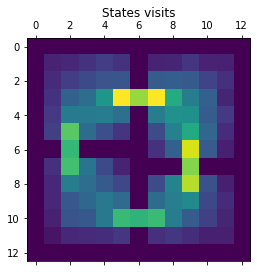

In [ ]:
options = find_options()

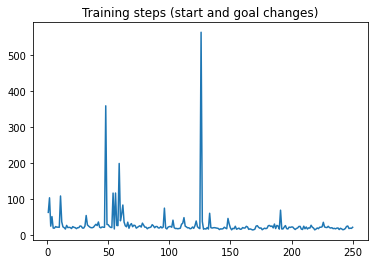

In [ ]:
train(options)

## Final Thoughts

I like this method more than the Feudal RL. The Option idea is really interesting and the relationship between options and actions makes them very intuitive. However, the introduction of the option components ($\pi, \beta, I$) adds some complexity that we didn't have with only primitive actions. Another problem with this implementation in specific is that we need to find the Options before learning the policy over options. Fortunately, [The Option-Critic Architecture](https://arxiv.org/abs/1609.05140) proposes a solution that learns both the internal policies and the termination conditions of options, in tandem with the policy over options.

When comparing Feudal to Options some ideas emerge. The way I see is that in Feudal each state at any level is an Option (trivial at Level-0), so basically Feudal is a stack of groups of policies over options, but the Options are predefined and not learned. While the Options Framework only has one layer of options, they are learned which can be an advantage. Obviously, this is a very (very) rough comparison. But I made this comparison because, in my opinion, it would be interesting to explore a new Options method that not only learns the options in parallel but also can introduce a new layer of options that controls the policies over options below. An example is how we behave in our lives, we have big long-term goals, mid-term goals, short-term goals and finally, we have daily goals. And all these goals influence in some way all the decisions we make, we set mid-term goals based on long-terms, short-term goals based on mid-term goals and so on. 

